In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:

#!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [3]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [4]:
# !cp "/content/drive/My Drive/Colab Notebooks/attention_keras/src/layers/attention.py" .

AttentionLayer was taken from here https://github.com/thushv89/attention_keras

In [1]:
from attention_keras.src.layers.attention import AttentionLayer

C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from os import listdir

C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [197]:
import tensorflow as tf
tf.__version__

'2.2.0'

#Read the dataset

CNN daily mail dataset consists of long news articles(an average of ~800 words). It consists of both articles and summaries of those articles.

In [7]:
import zipfile
import os

In [8]:


# zpfile = '/content/drive/My Drive/Colab Notebooks/cnn_stories.zip'
# z = zipfile.ZipFile(zpfile, 'r')
# z.extractall()

In [9]:
#print(os.listdir())

In [10]:
# load doc into memory
def load_doc(filename):
	# open the file as read only

	file = open(filename, encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights
 
# load all stories in a directory
def load_stories(directory):
	stories = list()
	for name in listdir(directory):
		filename = directory + '/' + name
		# load document
		doc = load_doc(filename)
		# split into story and highlights
		story, highlights = split_story(doc)
		# store
		stories.append({'story':story, 'highlights':highlights})
	return stories
 
# load stories
directory = 'cnn_stories/cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [11]:
import string


# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	# prepare a translation table to remove punctuation
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# strip source cnn office if it exists
		index = line.find('(CNN) -- ')
		if index > -1:
			line = line[index+len('(CNN)'):]
		# tokenize on white space
		line = line.split()
		# convert to lower case
		line = [word.lower() for word in line]
		# remove punctuation from each token
		line = [w.translate(table) for w in line]
		# remove tokens with numbers in them
		line = [word for word in line if word.isalpha()]
		# store as string
		cleaned.append(' '.join(line))
	# remove empty strings
	cleaned = [c for c in cleaned if len(c) > 0]
	return cleaned

# clean stories
for example in stories:
	example['story'] = clean_lines(example['story'].split('\n'))
	example['highlights'] = clean_lines(example['highlights'])

In [12]:
data = pd.DataFrame(stories)

In [13]:
data.head()

,story,highlights
0,"[its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria, obama sent a letter to the heads of the house and senate on saturday night hours afte...","[syrian official obama climbed to the top of the tree doesnt know how to get down, obama sends a letter to the heads of the house and senate, obama to seek congressional approval on military actio..."
1,"[usain bolt rounded off the world championships sunday by claiming his third gold in moscow as he anchored jamaica to victory in the mens relay, the fastest man in the world charged clear of unite...","[usain bolt wins third gold of world championship, anchors jamaica to relay victory, eighth gold at the championships for bolt, jamaica double up in womens relay]"
2,[the general services administration already under investigation for lavish spending allowed an employee to telecommute from hawaii even though he is based at the gsas kansas city missouri office ...,"[the employee in agencys kansas city office is among hundreds of virtual workers, the employees travel to and from the mainland us last year cost more than, the telecommuting program like all gsa ..."
3,[a medical doctor in vancouver british columbia said thursday that california arson suspect harry burkhart suffered from severe mental illness in when she examined him as part of a team of doctors...,"[new a canadian doctor says she was part of a team examining harry burkhart in, new diagnosis autism severe anxiety posttraumatic stress disorder and depression, burkhart is also suspected in a ge..."
4,"[police arrested another teen thursday the sixth suspect jailed in connection with the gang rape of a girl on a northern california high school campus, jose carlos montano was arrested on charges ...","[another arrest made in gang rape outside california school, investigators say up to people took part or stood and watched the assault, four suspects appeared in court thursday three wore bulletpr..."


In [14]:
data.rename(columns={"highlights": "Summary", "story": "Text"}, inplace=True)

In [17]:
data['Text'] = data['Text'].apply(lambda x: ' '.join(x) )

In [18]:
data['Summary'] = data['Summary'].apply(lambda x: ' '.join(x) )

In [19]:
data.head()

,Text,Summary
0,its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria obama sent a letter to the heads of the house and senate on saturday night hours after ...,syrian official obama climbed to the top of the tree doesnt know how to get down obama sends a letter to the heads of the house and senate obama to seek congressional approval on military action a...
1,usain bolt rounded off the world championships sunday by claiming his third gold in moscow as he anchored jamaica to victory in the mens relay the fastest man in the world charged clear of united ...,usain bolt wins third gold of world championship anchors jamaica to relay victory eighth gold at the championships for bolt jamaica double up in womens relay
2,the general services administration already under investigation for lavish spending allowed an employee to telecommute from hawaii even though he is based at the gsas kansas city missouri office a...,the employee in agencys kansas city office is among hundreds of virtual workers the employees travel to and from the mainland us last year cost more than the telecommuting program like all gsa pra...
3,a medical doctor in vancouver british columbia said thursday that california arson suspect harry burkhart suffered from severe mental illness in when she examined him as part of a team of doctors ...,new a canadian doctor says she was part of a team examining harry burkhart in new diagnosis autism severe anxiety posttraumatic stress disorder and depression burkhart is also suspected in a germa...
4,police arrested another teen thursday the sixth suspect jailed in connection with the gang rape of a girl on a northern california high school campus jose carlos montano was arrested on charges of...,another arrest made in gang rape outside california school investigators say up to people took part or stood and watched the assault four suspects appeared in court thursday three wore bulletproof...


### Drop Duplicates and NA values

In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

### Information about dataset


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89363 entries, 0 to 92578
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     89363 non-null  object
 1   Summary  89363 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


### Preprocessing

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate (устраним) punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Margarita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words = set(stopwords.words('english')) 

In [12]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [13]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed reviews

In [28]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [29]:
cleaned_summary[:10]

['syrian official obama climbed to the top of the tree doesnt know how to get down obama sends letter to the heads of the house and senate obama to seek congressional approval on military action against syria aim is to determine whether cw were used not by whom says un spokesman',
 'usain bolt wins third gold of world championship anchors jamaica to relay victory eighth gold at the championships for bolt jamaica double up in womens relay',
 'the employee in agencys kansas city office is among hundreds of virtual workers the employees travel to and from the mainland us last year cost more than the telecommuting program like all gsa practices is under review',
 'new canadian doctor says she was part of team examining harry burkhart in new diagnosis autism severe anxiety posttraumatic stress disorder and depression burkhart is also suspected in german arson probe officials say prosecutors believe the german national set string of fires in los angeles',
 'another arrest made in gang rape o

In [30]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [31]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### Understanding the distribution of the sequences

Here is an analysis of the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help to fix the maximum length of the sequence:

In [33]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

In [34]:
length_df.head()

,text,summary
0,899,51
1,309,26
2,556,37
3,531,45
4,166,32


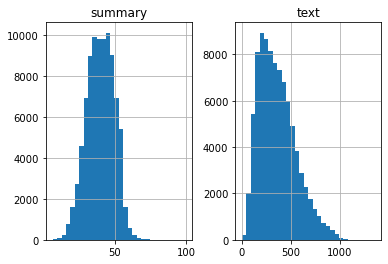

In [35]:


length_df.hist(bins = 30)
plt.show()

We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [36]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.862089031131801


In [37]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=500):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.777534074886417


Let us fix the maximum length of review to 30 and length of summary to 8.

In [38]:
max_text_len=30 #60
max_summary_len=8 #10

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [39]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])


In [41]:
len(cleaned_text)

89362

In [42]:
max_text_len

30

In [43]:
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if (len(cleaned_summary[i].split())>max_summary_len):
        short_summary.append(" ".join(cleaned_summary[i].split()[:8]))
    else:
        short_summary.append(cleaned_summary[i])
    
    if(len(cleaned_text[i].split())>max_text_len):
        short_text.append(" ".join(cleaned_text[i].split()[:30]))
    else:
        short_text.append(cleaned_text[i])
       
#     if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
#         short_text.append(cleaned_text[i])
#         short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

adding the **START** and **END** special tokens at the beginning and end of the summary.

In [47]:
df['summary'] = df['summary'].apply(lambda x : 'xl '+ x + ' xy')

We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [48]:
from sklearn.model_selection import train_test_split
x_tr1,x_val,y_tr1,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=False) 

### Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

### Text Tokenizer

In [53]:
pip install tokenizers

Note: you may need to restart the kernel to use updated packages.


In [54]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

In [55]:
bpe_tokeniser_from_files = ByteLevelBPETokenizer(
    vocab_file='C:/Users/Margarita/Documents/bpe_dropout/english/vocab.json',
    merges_file='C:/Users/Margarita/Documents/bpe_dropout/english/merges.txt',
    dropout=0.1,
)
#example
print('dropout =', bpe_tokeniser_from_files._parameters['dropout'])
for _ in range(5):
    print(bpe_tokeniser_from_files.encode('There are a lot of apples in the garden').tokens)

dropout = 0.1
['There', 'Ġare', 'Ġa', 'Ġlot', 'Ġof', 'Ġapples', 'Ġin', 'Ġth', 'e', 'Ġgarden']
['There', 'Ġar', 'e', 'Ġa', 'Ġlot', 'Ġo', 'f', 'Ġapples', 'Ġi', 'n', 'Ġthe', 'Ġgard', 'en']
['There', 'Ġare', 'Ġ', 'a', 'Ġlot', 'Ġ', 'of', 'Ġapple', 's', 'Ġin', 'Ġthe', 'Ġgarden']
['There', 'Ġare', 'Ġa', 'Ġlot', 'Ġof', 'Ġapples', 'Ġin', 'Ġthe', 'Ġgarden']
['There', 'Ġare', 'Ġa', 'Ġlot', 'Ġof', 'Ġapples', 'Ġin', 'Ġthe', 'Ġgarden']


In [56]:
#x_tokenizer=load("/content/drive/My Drive/my-bpe.tokenizer.json")

In [57]:
x_tokenizer = ByteLevelBPETokenizer(
    vocab_file='C:/Users/Margarita/Documents/bpe_dropout/english/vocab.json',
    merges_file='C:/Users/Margarita/Documents/bpe_dropout/english/merges.txt',
    dropout=0.1,
)

In [58]:
print(bpe_tokeniser_from_files.encode(x_tr1[0]).tokens)

['official', 'Ġus', 'Ġpresident', 'Ġbar', 'ack', 'Ġob', 'ama', 'Ġwants', 'Ġlawmakers', 'Ġweigh', 'Ġwhether', 'Ġu', 'se', 'Ġm', 'ilitary', 'Ġforce', 'Ġsy', 'ria', 'Ġob', 'ama', 'Ġsent', 'Ġl', 'etter', 'Ġheads', 'Ġhouse', 'Ġs', 'en', 'ate', 'Ġs', 'aturday', 'Ġnight', 'Ġhours', 'Ġannouncing', 'Ġbelieves', 'Ġmilitary', 'Ġaction', 'Ġsy', 'rian', 'Ġtargets', 'Ġright', 'Ġstep']


In [59]:
#x_tokenizer.save("/content/drive/My Drive/my-bpe.tokenizer.json")

In [60]:
x_token = x_tokenizer.encode_batch(list(x_tr1))            

In [64]:
len(x_token[1].tokens)

55

remove word with big length (they are rare)

In [65]:
max=0
for x in x_token:
    if len(x)>max:
        max=len(x)
        
print(max) 
max_text_len=max

80




Let us define the tokenizer 

In [68]:
#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.encode_batch(list(x_tr1))
x_val_seq   =   x_tokenizer.encode_batch(list(x_val))

In [69]:
#padding zero upto maximum length
x_tr    =   pad_sequences([x.ids for x in x_tr_seq],  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences([x.ids for x in x_val_seq], maxlen=max_text_len, padding='post')

In [70]:
dic={}
for x in x_tr:
    
    for word in x:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1
            
for x in x_val:
    
    for word in x:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1           

In [71]:
len(dic)

23685

define max integer representation of tokens

In [72]:
max=0
for x in x_tr:
    
    for word in x:
        
        if (word > max):
            max = word
for x in x_val:
    
    for word in x:
        
        if (word > max):
            max = word            
print(max)        

51998


In [73]:
#size of vocabulary ( +1 for padding token)
x_voc   =  max + 1

### Summary Tokenizer

Let us define the tokenizer with top most common words for summary.

In [74]:
#prepare a tokenizer for reviews on training data
y_tokenizer = ByteLevelBPETokenizer(
    vocab_file='C:/Users/Margarita/Documents/bpe_dropout/english/vocab.json',
    merges_file='C:/Users/Margarita/Documents/bpe_dropout/english/merges.txt',
    dropout=0.1,
)

In [75]:
#y_tokenizer.save("/content/drive/My Drive/my-bpe.y_tokenizer.json")

In [76]:
#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.encode_batch(list(y_tr1))
y_val_seq   =   y_tokenizer.encode_batch(list(y_val))

In [77]:
max=0
for x in y_tr_seq:
    if len(x)>max:
        max=len(x)
print(max) 
max_summary_len=max

30


In [79]:
#padding zero upto maximum length
y_tr    =   pad_sequences([y.ids for y in y_tr_seq],  maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences([y.ids for y in y_val_seq], maxlen=max_summary_len, padding='post')

In [80]:
dicy={}
for y in y_tr_seq:
    
    for word in y.tokens:
        if word in dicy:
            dicy[word]+=1
        else:
            dicy[word]=1

for y in y_val_seq:
    
    for word in y.tokens:
        if word in dicy:
            dicy[word]+=1
        else:
            dicy[word]=1            

In [81]:

len(dicy)

19739

In [82]:
max=0
for x in y_tr:
    
    for word in x:
        
        if (word > max):
            max = word
for x in y_val:
    
    for word in x:
        
        if (word > max):
            max = word            
print(max)       

51997


In [83]:
#size of vocabulary
y_voc  =   max +1

In [84]:
y_voc

51998

Here, I am deleting the rows that contain only **START** and **END** tokens

In [85]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [86]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [61]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 77)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 77, 100)      5199700     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 77, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

The concept of early stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [64]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [91]:
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

In [92]:
# Создаем коллбек сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [94]:
#history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es, cp_callback],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [95]:
#model.save_weights("bpe_model_short_30.h5")

In [96]:
# from google.colab import files
# files.download( "/content/bpe_model_short_30.h5" )

Load weights of already trained model

In [89]:
model.load_weights("bpe_model_short_30.h5")

#Diagnostic plot


In [97]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [180]:
dic={}

for i,v in zip(y_tr_seq, y_tr_seq):
    for x,y in zip(i.ids,v.tokens):
       if x not in dic:
          dic[x] = y

for i,v in zip(y_val_seq, y_val_seq):
    for x,y in zip(i.ids,v.tokens):
       if x not in dic:
          dic[x] = y

In [175]:
reverse_target_word_index={}
list_keys = list(dic.keys())
list_keys.sort()
for i in list_keys:
  reverse_target_word_index[i]=dic[i]

In [176]:
dicx={}

for i,v in zip(x_tr_seq, x_tr_seq):
    for x,y in zip(i.ids,v.tokens):
       if x not in dicx:
          dicx[x] = y

for i,v in zip(x_val_seq, x_val_seq):
    for x,y in zip(i.ids,v.tokens):
       if x not in dicx:
          dicx[x] = y

In [177]:
reverse_source_word_index={}
list_keys = list(dicx.keys())
list_keys.sort()
for i in list_keys:
  reverse_source_word_index[i]=dicx[i]


In [178]:
dic={}

for i,v in zip(y_tr_seq, y_tr_seq):
    for x,y in zip(i.ids,v.tokens):
       if y not in dic:
          dic[y] = x

for i,v in zip(y_val_seq, y_val_seq):
    for x,y in zip(i.ids,v.tokens):
       if y not in dic:
          dic[y] = x

In [179]:
target_word_index={}
list_d = list(dic.items())
list_d.sort(key=lambda i: i[1])

for i in list_d:
      target_word_index[i[0]]=i[1]


# Inference

Set up the inference for the encoder and decoder:

In [73]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process, using y_tokenizer.decode()

In [120]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    test=[]
    # Populate the first word of target sequence with the start word.
    #target_seq[0, 0] = target_word_index['x']

    stop_condition = False
    decoded_sentence = ''
    decoded_sentence_test = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        test.append(sampled_token_index)
        
        sampled_token = reverse_target_word_index[sampled_token_index]
        #print(sampled_token)
        if(sampled_token!='y') or (sampled_token!='Ġx'):
            decoded_sentence += sampled_token + ' '
        
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'Ġx' or sampled_token == 'xy' or sampled_token == '' or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c
      
    decoded_sentence_test = y_tokenizer.decode(test[1:len(test)-1]) 
    return decoded_sentence_test

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [108]:
def seq2summary(input_seq):
#    return y_tokenizer.decode(input_seq)[2:len(input_seq)-1] 
     return y_tokenizer.decode(input_seq)[2:len(input_seq)+1]  

def seq2text(input_seq):
    return x_tokenizer.decode(input_seq) 

Here are a few summaries generated by the model:

In [109]:
reverse_target_word_index[0]=''

In [121]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: official us president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets right step<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
Original summary:  syrian official obama clim
Predicted summary:  obama says he will not be the


Review: usain bolt rounded world championships sunday claiming third gold moscow anchored jamaica victory mens relay fastest man world charged clear united states rival justin gatlin jamaican quartet nesta carter kemar<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
Original summary:  usain bolt wins third gold
Predicted summary:  usain bolt wins the world cup final


Review: general services administration already investigation lavish spending allowed employee telecommute hawaii even though based gsas kansas city missouri office cnn investigation found cost busin

### Preparation for using metric Rouge

Make the dataframe with original and predicted summaries

In [127]:
original_summary = []
predicted_summary = []

In [128]:
for i in range(len(y_tr)):
    original_summary.append(seq2summary(y_tr[i]))

In [136]:
for i in range(len(original_summary)):
    original_summary[i] = re.sub('<s>','', original_summary[i])
    original_summary[i] = re.sub('<s','', original_summary[i])
    original_summary[i] = re.sub('xy','', original_summary[i])
    original_summary[i] = re.sub('<','', original_summary[i])
    original_summary[i] = original_summary[i].strip()

In [181]:
original_summary[:5]

['syrian official obama clim',
 'usain bolt wins third gold',
 'the employee in agencys ka',
 'new canadian doctor says s',
 'another arrest made in gan']

In [137]:
for i in range(len(y_tr)):
    predicted_summary.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))

In [134]:
for i in range(len(predicted_summary)):
    predicted_summary[i] = re.sub('<s>','', predicted_summary[i])
    predicted_summary[i] = re.sub('<s','', predicted_summary[i])
    predicted_summary[i] = re.sub('xy','', predicted_summary[i])
    predicted_summary[i] = re.sub('<','', predicted_summary[i])
    predicted_summary[i] = predicted_summary[i].strip()

In [182]:
predicted_summary[:5]

['obama says he will not be the',
 'usain bolt wins the world cup final',
 'new york city council says the country',
 'john avlon jr was found dead in',
 'new police say they are arrested in']

In [138]:
dataframe = pd.DataFrame({'original_summary': original_summary, 'predicted_summary':predicted_summary})

Delete empty predictions

In [143]:
np.where(dataframe['predicted_summary']=='')

(array([    5,     9,    12, ..., 80413, 80421, 80422], dtype=int64),)

In [140]:
np.where(dataframe['original_summary']=='')

(array([], dtype=int64),)

In [149]:
dataframe = dataframe.drop(np.where(dataframe['predicted_summary']=='')[0])

In [150]:
dataframe = dataframe.reset_index(drop=True)

In [151]:
dataframe.shape

(57726, 2)

In [152]:
dataframe.to_csv('predictions_cnn_without_empty.csv')

Create two folders with txt original and predicted summaries

In [153]:
for i in range(len(dataframe)):
    
    f = open('original_cnn/original' + str(i) + '.txt', 'w', encoding="utf-8")
    f.write(dataframe['original_summary'][i])

In [163]:
for i in range(len(dataframe)):
    
    f = open('predicted_cnn/predicted' + str(i) + '.txt', 'w', encoding="utf-8")
    f.write(dataframe['predicted_summary'][i])

Import pyrouge

In [189]:
from pyrouge import Rouge155

In [190]:
r = Rouge155('C:/Users/Margarita/pyrouge/rouge/tools/ROUGE-1.5.5')
    

2020-08-11 13:45:30,235 [MainThread  ] [INFO ]  Set ROUGE home directory to C:/Users/Margarita/pyrouge/rouge/tools/ROUGE-1.5.5.


In [192]:
r.system_dir = 'C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/original' # Summaries to score against.
r.model_dir = 'C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/predicted'  # Summaries generated by the model

In [192]:
r.system_filename_pattern = 'original_summary(\d+).txt'
r.model_filename_pattern = 'predicted_summary#ID#.txt'

In [195]:
output = r.convert_and_evaluate()
print(output)

---------------------------------------------
1 ROUGE-1 Average_R: 0.13240 (95%-conf.int. 0.12982 - 0.13498)
1 ROUGE-1 Average_P: 0.10272 (95%-conf.int. 0.10063 - 0.10493)
1 ROUGE-1 Average_F: 0.10960 (95%-conf.int. 0.10751 - 0.11176)
---------------------------------------------
1 ROUGE-2 Average_R: 0.03601 (95%-conf.int. 0.03428 - 0.03763)
1 ROUGE-2 Average_P: 0.02926 (95%-conf.int. 0.02781 - 0.03072)
1 ROUGE-2 Average_F: 0.03040 (95%-conf.int. 0.02891 - 0.03183)
---------------------------------------------
1 ROUGE-3 Average_R: 0.00677 (95%-conf.int. 0.00609 - 0.00746)
1 ROUGE-3 Average_P: 0.00665 (95%-conf.int. 0.00596 - 0.00735)
1 ROUGE-3 Average_F: 0.00652 (95%-conf.int. 0.00586 - 0.00719)
---------------------------------------------
1 ROUGE-4 Average_R: 0.00298 (95%-conf.int. 0.00250 - 0.00349)
1 ROUGE-4 Average_P: 0.00274 (95%-conf.int. 0.00228 - 0.00324)
1 ROUGE-4 Average_F: 0.00281 (95%-conf.int. 0.00235 - 0.00332)
---------------------------------------------
1 ROUGE-L Aver

In [196]:
dict_output = r.output_to_dict(output)
